# Exploring LSTM models 

In this notebook we run lstm models on Infodengue data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir("..")
#from infodenguepredict.models.deeplearning import *
from infodenguepredict.models.deeplearning.preprocessing import *
#from infodenguepredict.models.deeplearning.lstm import lstm.build_model
import pickle

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.metrics import *

from time import time

## Loading the data

We perform our experiments on data from Rio de Janeiro. Let us first read all our data.

In [4]:
cluster = pd.read_csv("~/data/infodengue/3304557_cluster.csv",index_col=0)
cluster.head()

,casos_3306206,casos_est_3306206,casos_est_min_3306206,casos_est_max_3306206,p_rt1_3306206,p_inc100k_3306206,temp_min_3306206,temp_max_3306206,umid_min_3306206,pressao_min_3306206,...,casos_3300456,casos_est_3300456,casos_est_min_3300456,casos_est_max_3300456,p_rt1_3300456,p_inc100k_3300456,temp_min_3300456,temp_max_3300456,umid_min_3300456,pressao_min_3300456
2010-01-03,1,1.0,1,1,0.0,2.80725,24.333333,33.000000,42.000000,1009.666667,...,3,3.0,3,3,0.0,0.607114,24.333333,33.000000,42.000000,1009.666667
2010-01-10,0,0.0,0,0,0.0,0.00000,25.428571,34.000000,43.285714,1008.000000,...,6,6.0,6,6,0.0,1.214230,25.428571,34.000000,43.285714,1008.000000
2010-01-17,0,0.0,0,0,0.0,0.00000,24.142857,34.000000,43.857143,1010.285714,...,1,1.0,1,1,0.0,0.202371,24.142857,34.000000,43.857143,1010.285714
2010-01-24,0,0.0,0,0,0.0,0.00000,23.714286,34.285714,39.285714,1009.000000,...,4,4.0,4,4,0.0,0.809486,23.714286,34.285714,39.285714,1009.000000
2010-01-31,0,0.0,0,0,0.0,0.00000,23.857143,33.857143,41.285714,1009.857143,...,9,9.0,9,9,0.0,1.821340,23.857143,33.857143,41.285714,1009.857143


The city of Rio is coded as cluster `3304557`. We cn easily filter the dataframe above to get only the data corresponding to this cluster.

In [5]:
cluster_rj = cluster[[c for c in cluster.columns if "3304557" in c.split("_")]]
print(cluster_rj.shape)
print(cluster_rj.columns)
cluster_rj.head()

(488, 10)
Index(['casos_3304557', 'casos_est_3304557', 'casos_est_min_3304557',
       'casos_est_max_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557'],
      dtype='object')


,casos_3304557,casos_est_3304557,casos_est_min_3304557,casos_est_max_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,30,30.0,30,30,0.0,0.461621,24.333333,33.000000,42.000000,1009.666667
2010-01-10,46,46.0,46,46,0.0,0.707819,25.428571,34.000000,43.285714,1008.000000
2010-01-17,30,30.0,30,30,0.0,0.461621,24.142857,34.000000,43.857143,1010.285714
2010-01-24,51,51.0,51,51,0.0,0.784756,23.714286,34.285714,39.285714,1009.000000
2010-01-31,58,58.0,58,58,0.0,0.892467,23.857143,33.857143,41.285714,1009.857143


Our goal is to predict the first column, `casos_3304557` from the columns `p_rt1_3304557`, `p_inc100k_3304557`, `temp_min_3304557`, `temp_max_3304557`, `umid_min_3304557`, `pressao_min_3304557`.

In [6]:
usecols = ['casos_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557']
data = cluster_rj[usecols]
data.head()

,casos_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,30,0.0,0.461621,24.333333,33.000000,42.000000,1009.666667
2010-01-10,46,0.0,0.707819,25.428571,34.000000,43.285714,1008.000000
2010-01-17,30,0.0,0.461621,24.142857,34.000000,43.857143,1010.285714
2010-01-24,51,0.0,0.784756,23.714286,34.285714,39.285714,1009.000000
2010-01-31,58,0.0,0.892467,23.857143,33.857143,41.285714,1009.857143


Let us plot the features of our dataset.

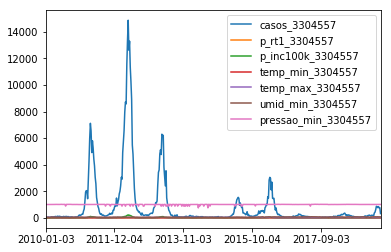

In [7]:
data.plot()

## Normalizing and splitting train/tests sets

In [8]:
### Normalizing data
data, _ = normalize_data(data)
data.head()

,casos_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
0,0.002018,0.0,0.002018,0.920721,0.891892,0.488451,0.982712
1,0.003094,0.0,0.003094,0.962162,0.918919,0.503404,0.981090
2,0.002018,0.0,0.002018,0.913514,0.918919,0.510049,0.983315
3,0.003430,0.0,0.003430,0.897297,0.926641,0.456885,0.982063
4,0.003901,0.0,0.003901,0.902703,0.915058,0.480144,0.982898


In [9]:
### Splitting train/test sets
X_train, y_train, X_test, y_test = split_data(data, look_back=10, ratio=0.8, predict_n=5, Y_column=0)

train size:  380


We are looking back 10 weeks to get our training data:

In [10]:
X_train.shape

(380, 10, 7)

In [11]:
predict_n = 5
#y_train = np.reshape(y_train,(-1,*y_train.shape))
#y_test = np.reshape(y_test,(*y_test.shape,1))

In [12]:
y_train.shape

(380, 5)

In [13]:
y_train

array([[0.0047081 , 0.00524617, 0.00544794, 0.0047081 , 0.00780199],
       [0.00524617, 0.00544794, 0.0047081 , 0.00780199, 0.00363196],
       [0.00544794, 0.0047081 , 0.00780199, 0.00363196, 0.00659134],
       ...,
       [0.00490987, 0.00316115, 0.00242131, 0.00242131, 0.00242131],
       [0.00316115, 0.00242131, 0.00242131, 0.00242131, 0.00221953],
       [0.00242131, 0.00242131, 0.00242131, 0.00221953, 0.00269034]])

## LSTM model

In [29]:
hidden = 4
look_back=10
features = 7
batch_size = 38
predict_n = 5

model = Sequential()

model.add(LSTM(hidden,input_shape=(look_back, features),stateful=True, \
batch_input_shape=(batch_size, look_back, features), return_sequences=True,\
dropout=0.2, recurrent_dropout=0.2, implementation=2, unit_forget_bias=True,))
    
model.add(LSTM(hidden,input_shape=(look_back, features),stateful=True, \
batch_input_shape=(batch_size, look_back, features), return_sequences=True, activation='relu',\
dropout=0.2, recurrent_dropout=0.2, implementation=2, unit_forget_bias=True,))

model.add(LSTM(hidden,input_shape=(look_back, features),stateful=True, \
batch_input_shape=(batch_size, look_back, features), return_sequences=False, activation='relu',\
dropout=0.2, recurrent_dropout=0.2, implementation=2, unit_forget_bias=True,))

model.add(Dense(units=predict_n, activation="relu", kernel_initializer="random_uniform",\
                bias_initializer="zeros",))

start = time()
model.compile(loss="msle", optimizer="nadam", metrics=["accuracy", "mape", "mse"])
print("Compilation Time : ", time() - start)
#plot_model(model, to_file="LSTM_model.png")
print(model.summary())



Compilation Time :  0.01875019073486328
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (38, 10, 4)               192       
_________________________________________________________________
lstm_20 (LSTM)               (38, 10, 4)               144       
_________________________________________________________________
lstm_21 (LSTM)               (38, 4)                   144       
_________________________________________________________________
dense_7 (Dense)              (38, 5)                   25        
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=500,validation_split=0.1)

Train on 342 samples, validate on 38 samples
Epoch 1/500
342/342 [==============================] - 2s 6ms/step - loss: 0.0181 - acc: 0.2164 - mean_absolute_percentage_error: 92.1396 - mean_squared_error: 0.0292 - val_loss: 7.9072e-05 - val_acc: 0.4211 - val_mean_absolute_percentage_error: 162.3061 - val_mean_squared_error: 8.0589e-05
Epoch 2/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0169 - acc: 0.2398 - mean_absolute_percentage_error: 180.2116 - mean_squared_error: 0.0277 - val_loss: 4.2150e-04 - val_acc: 0.3684 - val_mean_absolute_percentage_error: 366.9957 - val_mean_squared_error: 4.3675e-04
Epoch 3/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0159 - acc: 0.2076 - mean_absolute_percentage_error: 298.3513 - mean_squared_error: 0.0264 - val_loss: 0.0013 - val_acc: 0.3947 - val_mean_absolute_percentage_error: 614.0129 - val_mean_squared_error: 0.0013
Epoch 4/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0152 - a

342/342 [==============================] - 1s 2ms/step - loss: 0.0124 - acc: 0.2018 - mean_absolute_percentage_error: 419.2731 - mean_squared_error: 0.0204 - val_loss: 9.9771e-04 - val_acc: 0.0789 - val_mean_absolute_percentage_error: 448.9287 - val_mean_squared_error: 0.0011
Epoch 30/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0107 - acc: 0.2018 - mean_absolute_percentage_error: 357.9986 - mean_squared_error: 0.0182 - val_loss: 7.2511e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 390.3334 - val_mean_squared_error: 7.7105e-04
Epoch 31/500
342/342 [==============================] - 0s 779us/step - loss: 0.0117 - acc: 0.1871 - mean_absolute_percentage_error: 347.4988 - mean_squared_error: 0.0197 - val_loss: 6.1200e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 376.1628 - val_mean_squared_error: 6.4516e-04
Epoch 32/500
342/342 [==============================] - 0s 863us/step - loss: 0.0119 - acc: 0.2193 - mean_absolute_percentage_error: 

Epoch 57/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0086 - acc: 0.2018 - mean_absolute_percentage_error: 255.4335 - mean_squared_error: 0.0143 - val_loss: 2.9461e-04 - val_acc: 0.0789 - val_mean_absolute_percentage_error: 291.0714 - val_mean_squared_error: 3.0488e-04
Epoch 58/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0082 - acc: 0.2193 - mean_absolute_percentage_error: 221.6478 - mean_squared_error: 0.0136 - val_loss: 3.4123e-04 - val_acc: 0.0263 - val_mean_absolute_percentage_error: 268.1508 - val_mean_squared_error: 3.5999e-04
Epoch 59/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0097 - acc: 0.2018 - mean_absolute_percentage_error: 265.8750 - mean_squared_error: 0.0161 - val_loss: 3.4692e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 318.1057 - val_mean_squared_error: 3.5943e-04
Epoch 60/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0095 - acc: 0.1842 - mean_absolute_perce

Epoch 85/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0085 - acc: 0.2047 - mean_absolute_percentage_error: 234.2791 - mean_squared_error: 0.0140 - val_loss: 1.4752e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 217.8743 - val_mean_squared_error: 1.5123e-04
Epoch 86/500
342/342 [==============================] - 0s 985us/step - loss: 0.0080 - acc: 0.2135 - mean_absolute_percentage_error: 202.0052 - mean_squared_error: 0.0134 - val_loss: 9.5466e-05 - val_acc: 0.0263 - val_mean_absolute_percentage_error: 167.1915 - val_mean_squared_error: 9.7657e-05
Epoch 87/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0092 - acc: 0.1813 - mean_absolute_percentage_error: 255.6561 - mean_squared_error: 0.0152 - val_loss: 2.5882e-04 - val_acc: 0.1842 - val_mean_absolute_percentage_error: 291.8352 - val_mean_squared_error: 2.6667e-04
Epoch 88/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0108 - acc: 0.2222 - mean_absolute_per

Epoch 113/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0074 - acc: 0.2105 - mean_absolute_percentage_error: 201.3416 - mean_squared_error: 0.0123 - val_loss: 2.4699e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 281.5245 - val_mean_squared_error: 2.5447e-04
Epoch 114/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0103 - acc: 0.2135 - mean_absolute_percentage_error: 261.2028 - mean_squared_error: 0.0178 - val_loss: 4.3323e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 348.2639 - val_mean_squared_error: 4.5431e-04
Epoch 115/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0084 - acc: 0.2135 - mean_absolute_percentage_error: 218.6383 - mean_squared_error: 0.0145 - val_loss: 9.3455e-05 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 164.5330 - val_mean_squared_error: 9.5546e-05
Epoch 116/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0088 - acc: 0.2222 - mean_absolute_p

Epoch 141/500
342/342 [==============================] - 0s 550us/step - loss: 0.0080 - acc: 0.2076 - mean_absolute_percentage_error: 207.7558 - mean_squared_error: 0.0134 - val_loss: 1.1007e-04 - val_acc: 0.1053 - val_mean_absolute_percentage_error: 180.1970 - val_mean_squared_error: 1.1267e-04
Epoch 142/500
342/342 [==============================] - 0s 716us/step - loss: 0.0100 - acc: 0.1959 - mean_absolute_percentage_error: 241.0148 - mean_squared_error: 0.0174 - val_loss: 1.0388e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 173.0095 - val_mean_squared_error: 1.0633e-04
Epoch 143/500
342/342 [==============================] - 0s 951us/step - loss: 0.0078 - acc: 0.1988 - mean_absolute_percentage_error: 209.8958 - mean_squared_error: 0.0132 - val_loss: 8.9925e-05 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 160.5565 - val_mean_squared_error: 9.1932e-05
Epoch 144/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0077 - acc: 0.1901 - mean_abso

Epoch 169/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0082 - acc: 0.1696 - mean_absolute_percentage_error: 203.1720 - mean_squared_error: 0.0140 - val_loss: 1.6282e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 225.8199 - val_mean_squared_error: 1.6709e-04
Epoch 170/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0083 - acc: 0.1901 - mean_absolute_percentage_error: 222.9513 - mean_squared_error: 0.0141 - val_loss: 1.7639e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 232.1143 - val_mean_squared_error: 1.8121e-04
Epoch 171/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0081 - acc: 0.2105 - mean_absolute_percentage_error: 216.0694 - mean_squared_error: 0.0136 - val_loss: 1.1534e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 185.6420 - val_mean_squared_error: 1.1810e-04
Epoch 172/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0080 - acc: 0.1667 - mean_absolute_p

Epoch 197/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0067 - acc: 0.1930 - mean_absolute_percentage_error: 217.5312 - mean_squared_error: 0.0108 - val_loss: 1.0911e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 186.4665 - val_mean_squared_error: 1.1157e-04
Epoch 198/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0090 - acc: 0.1754 - mean_absolute_percentage_error: 183.6184 - mean_squared_error: 0.0154 - val_loss: 1.7189e-04 - val_acc: 0.1842 - val_mean_absolute_percentage_error: 236.5454 - val_mean_squared_error: 1.7639e-04
Epoch 199/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0081 - acc: 0.2047 - mean_absolute_percentage_error: 202.1990 - mean_squared_error: 0.0139 - val_loss: 2.6553e-04 - val_acc: 0.1053 - val_mean_absolute_percentage_error: 293.1546 - val_mean_squared_error: 2.7365e-04
Epoch 200/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0079 - acc: 0.1754 - mean_absolute_p

Epoch 225/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0070 - acc: 0.2047 - mean_absolute_percentage_error: 208.6896 - mean_squared_error: 0.0116 - val_loss: 2.6338e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 290.8746 - val_mean_squared_error: 2.7148e-04
Epoch 226/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0073 - acc: 0.1725 - mean_absolute_percentage_error: 223.7376 - mean_squared_error: 0.0121 - val_loss: 6.0523e-05 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 132.1537 - val_mean_squared_error: 6.1657e-05
Epoch 227/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0092 - acc: 0.2076 - mean_absolute_percentage_error: 224.3310 - mean_squared_error: 0.0155 - val_loss: 2.7431e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 297.1829 - val_mean_squared_error: 2.8281e-04
Epoch 228/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0093 - acc: 0.2047 - mean_absolute_p

Epoch 253/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0075 - acc: 0.2076 - mean_absolute_percentage_error: 194.0159 - mean_squared_error: 0.0129 - val_loss: 7.5686e-05 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 149.7214 - val_mean_squared_error: 7.7229e-05
Epoch 254/500
342/342 [==============================] - 0s 962us/step - loss: 0.0078 - acc: 0.1842 - mean_absolute_percentage_error: 176.2368 - mean_squared_error: 0.0133 - val_loss: 5.2426e-05 - val_acc: 0.1053 - val_mean_absolute_percentage_error: 122.4034 - val_mean_squared_error: 5.3347e-05
Epoch 255/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0086 - acc: 0.2135 - mean_absolute_percentage_error: 184.5654 - mean_squared_error: 0.0148 - val_loss: 1.6172e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 222.9681 - val_mean_squared_error: 1.6601e-04
Epoch 256/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0074 - acc: 0.2047 - mean_absolute

Epoch 281/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0079 - acc: 0.1988 - mean_absolute_percentage_error: 157.3842 - mean_squared_error: 0.0134 - val_loss: 5.2516e-04 - val_acc: 0.1053 - val_mean_absolute_percentage_error: 373.3460 - val_mean_squared_error: 5.4909e-04
Epoch 282/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0079 - acc: 0.1725 - mean_absolute_percentage_error: 221.3951 - mean_squared_error: 0.0137 - val_loss: 1.7464e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 236.9431 - val_mean_squared_error: 1.7931e-04
Epoch 283/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0079 - acc: 0.1667 - mean_absolute_percentage_error: 189.1829 - mean_squared_error: 0.0136 - val_loss: 1.8083e-04 - val_acc: 0.3947 - val_mean_absolute_percentage_error: 244.1007 - val_mean_squared_error: 1.8561e-04
Epoch 284/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0077 - acc: 0.2047 - mean_absolute_p

Epoch 309/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0077 - acc: 0.1988 - mean_absolute_percentage_error: 182.0373 - mean_squared_error: 0.0133 - val_loss: 1.2316e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 201.5909 - val_mean_squared_error: 1.2598e-04
Epoch 310/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0072 - acc: 0.2105 - mean_absolute_percentage_error: 185.0274 - mean_squared_error: 0.0120 - val_loss: 1.4054e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 213.8371 - val_mean_squared_error: 1.4399e-04
Epoch 311/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0064 - acc: 0.1842 - mean_absolute_percentage_error: 170.9183 - mean_squared_error: 0.0104 - val_loss: 2.0741e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 260.7150 - val_mean_squared_error: 2.1323e-04
Epoch 312/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0088 - acc: 0.1871 - mean_absolute_p

Epoch 337/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0071 - acc: 0.1988 - mean_absolute_percentage_error: 185.9844 - mean_squared_error: 0.0117 - val_loss: 1.2045e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 196.9106 - val_mean_squared_error: 1.2325e-04
Epoch 338/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0083 - acc: 0.1988 - mean_absolute_percentage_error: 176.7543 - mean_squared_error: 0.0142 - val_loss: 9.6825e-05 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 177.3763 - val_mean_squared_error: 9.8872e-05
Epoch 339/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0065 - acc: 0.2222 - mean_absolute_percentage_error: 170.6298 - mean_squared_error: 0.0107 - val_loss: 1.6949e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 235.0531 - val_mean_squared_error: 1.7392e-04
Epoch 340/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0073 - acc: 0.1988 - mean_absolute_p

Epoch 365/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0069 - acc: 0.2164 - mean_absolute_percentage_error: 186.1097 - mean_squared_error: 0.0112 - val_loss: 1.4381e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 216.2948 - val_mean_squared_error: 1.4735e-04
Epoch 366/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0077 - acc: 0.1871 - mean_absolute_percentage_error: 178.8789 - mean_squared_error: 0.0129 - val_loss: 1.5295e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 221.8817 - val_mean_squared_error: 1.5683e-04
Epoch 367/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0093 - acc: 0.2105 - mean_absolute_percentage_error: 201.5876 - mean_squared_error: 0.0157 - val_loss: 2.0901e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 260.5077 - val_mean_squared_error: 2.1486e-04
Epoch 368/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0065 - acc: 0.1959 - mean_absolute_p

Epoch 393/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0080 - acc: 0.1842 - mean_absolute_percentage_error: 190.4351 - mean_squared_error: 0.0137 - val_loss: 1.1230e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 189.3069 - val_mean_squared_error: 1.1484e-04
Epoch 394/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0072 - acc: 0.1959 - mean_absolute_percentage_error: 185.0600 - mean_squared_error: 0.0122 - val_loss: 8.8518e-05 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 166.4774 - val_mean_squared_error: 9.0372e-05
Epoch 395/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0070 - acc: 0.2105 - mean_absolute_percentage_error: 188.2157 - mean_squared_error: 0.0121 - val_loss: 6.5572e-05 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 142.3529 - val_mean_squared_error: 6.6788e-05
Epoch 396/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0066 - acc: 0.1871 - mean_absolute_p

Epoch 421/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0071 - acc: 0.2105 - mean_absolute_percentage_error: 193.9563 - mean_squared_error: 0.0120 - val_loss: 1.5183e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 220.6650 - val_mean_squared_error: 1.5571e-04
Epoch 422/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0077 - acc: 0.1813 - mean_absolute_percentage_error: 186.5283 - mean_squared_error: 0.0131 - val_loss: 7.3086e-05 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 150.8363 - val_mean_squared_error: 7.4501e-05
Epoch 423/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0078 - acc: 0.1842 - mean_absolute_percentage_error: 158.6511 - mean_squared_error: 0.0131 - val_loss: 1.6380e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 230.0673 - val_mean_squared_error: 1.6803e-04
Epoch 424/500
342/342 [==============================] - 1s 2ms/step - loss: 0.0075 - acc: 0.2135 - mean_absolute_p

Epoch 449/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0082 - acc: 0.1901 - mean_absolute_percentage_error: 196.8743 - mean_squared_error: 0.0140 - val_loss: 1.2726e-04 - val_acc: 0.3947 - val_mean_absolute_percentage_error: 205.7478 - val_mean_squared_error: 1.3021e-04
Epoch 450/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0076 - acc: 0.2193 - mean_absolute_percentage_error: 194.4587 - mean_squared_error: 0.0127 - val_loss: 1.7079e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 237.8959 - val_mean_squared_error: 1.7521e-04
Epoch 451/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0081 - acc: 0.2018 - mean_absolute_percentage_error: 196.4126 - mean_squared_error: 0.0138 - val_loss: 1.2290e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 200.2174 - val_mean_squared_error: 1.2575e-04
Epoch 452/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0064 - acc: 0.1959 - mean_absolute_p

Epoch 477/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0071 - acc: 0.2105 - mean_absolute_percentage_error: 166.5637 - mean_squared_error: 0.0118 - val_loss: 4.5970e-05 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 115.8136 - val_mean_squared_error: 4.6715e-05
Epoch 478/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0073 - acc: 0.2047 - mean_absolute_percentage_error: 170.8005 - mean_squared_error: 0.0124 - val_loss: 1.6664e-04 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 233.1967 - val_mean_squared_error: 1.7094e-04
Epoch 479/500
342/342 [==============================] - 0s 1ms/step - loss: 0.0077 - acc: 0.2135 - mean_absolute_percentage_error: 185.4631 - mean_squared_error: 0.0132 - val_loss: 8.9968e-05 - val_acc: 0.0526 - val_mean_absolute_percentage_error: 170.4259 - val_mean_squared_error: 9.1825e-05
Epoch 480/500
342/342 [==============================] - 0s 892us/step - loss: 0.0074 - acc: 0.1988 - mean_absolute

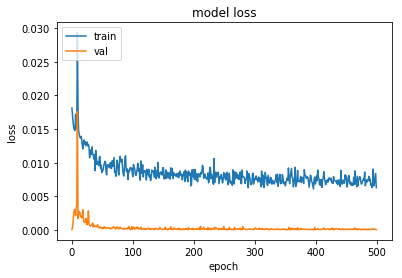

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()